# Using pure Numpy to build a 3 layer neural network

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import numpy as np

# Utility function for 3D plot
We will be using this 3D plot in order to plot the real values of y with respect to the predicted values of y. This will help us in understading how those two values are related and how they change with or without activation function.

In [34]:
def plot_3d(comp, graph_title, X, y, y_pred=None):
    X_tnse = TSNE(n_components=comp, random_state=123).fit_transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
    ax.set_title(graph_title)
    if y_pred is not None:
        ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
    plt.legend()
    plt.show()

# Generating Sample data 3 inputs & 2 output

In [35]:
n = 200

# We need to take 3 inputs
inputs_dimensions = 3

# We need to have 2 outputs
output_dimensions = 2

# Setup some random seed
np.random.seed(2232)

# Generating X with 3 dimentions
X = np.random.uniform(-1, 1, (n, inputs_dimensions))
print('Sample Value for X:' + str(X[:3]))

# Generating the value of the y_true
weights_true = np.array([[4,3,-2],[-1,-1,3]])
bias_true = np.array([[1],[1]])

y_true = (9 * X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

print('Sample Value for y:'+ str(y_true[:3]))


Sample Value for X:[[-0.34381746 -0.21874254  0.4211479 ]
 [ 0.63720264 -0.36557595 -0.84401555]
 [ 0.12846155 -0.76045417  0.91954116]]
Sample Value for y:[[ 0.48110695  6.12034493]
 [ 9.54300863 12.57305053]
 [-1.6186757  21.86749061]]


# Plotting the data in a 3-Dimentional Plane

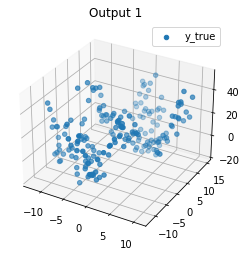

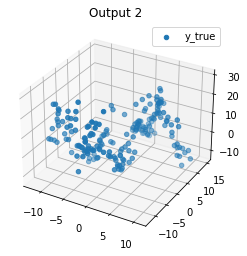

In [36]:
plot_3d(2, 'Output 1', X, y_true[:,0])
plot_3d(2, 'Output 2', X, y_true[:,1])

# Hyperparameters - Various Parameters that we will be using

In [37]:
# Number of Iterations
epochs = 200

# Learning rate of the algorithm
learning_rate = 0.01

# Inputs and outputs size. i.e 2 and 3 relatively
inputs = X.shape[1]
outputs = y_true.shape[1]

print(inputs)
print(outputs)

3
2


# Creating Layers for the Neural Network

In [38]:
class Layer:
    def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
        self.num_input_nodes = num_input_nodes
        self.num_output_nodes = num_output_nodes
        # Init layer with random weights and bias
        self.weights = np.random.rand(num_input_nodes, num_output_nodes)
        self.bias = np.random.rand((1))
        self.X = np.zeros([num_input_nodes])
        # Set activation function
        if activation == 'relu':
            self.activation = Relu()
        else: 
            self.activation = None
  
    def forward(self, X):
        self.X = X.copy()
        self.Z = X @ self.weights + self.bias
        # Pass output to activation function
        if self.activation == None:
            return self.Z 
        else:
            return self.activation.forward(self.Z)

    # Refered for math resource: https://www.kdnuggets.com/2019/08/numpy-neural-networks-computational-graphs.html
    def backward(self, upstream_gradient):
        curr_upstream_gradient = upstream_gradient.copy()
        if self.activation != None:
            curr_upstream_gradient = self.activation.backward(curr_upstream_gradient)

        self.dJdW = self.X.T @ curr_upstream_gradient
        self.dJdb = curr_upstream_gradient.sum()
        self.dJdX = curr_upstream_gradient @ self.weights.T
        return self.dJdX

    # Update weight and bias params with learning rate step size
    def update(self, lr):
        self.weights = self.weights - lr * self.dJdW
        self.bias = self.bias - lr * self.dJdb

# Defining the Activation function

In [39]:
class Relu:
    def __init__(self):
        self.input = np.array([])

    def forward(self, input):
        self.input = input.copy()
        self.output = np.clip(self.input, 0, None)
        return self.output
  
    # If input is less than 0, derivative is 0. If input is greater than 0, derivative is 1
    def backward(self, upstream_gradient):
        return (self.input > 0) * upstream_gradient
  
    # No update needed to ReLU members
    def update(self, lr):
        return

    def __str__(self):
        return 'ReLu'

# Defining the Model

In [40]:
class Model:
    def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]

        self.layers = []
        for i in range(len(layers[:-1])):
          # Don't add activation function to last layer because this is a regression problem
            if i == len(layers[:-1]) - 1:
                self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
            else:
                self.layers.append(Layer(layers[i], layers[i + 1], activation))

        # Print network architecture for debugging
        print('Layerwise Neural Net Architecture:')
        for i, layer in enumerate(self.layers):
            print('=== Layer {} ==='.format(i))
            print(layer)
        print()

    def forward(self, inputs):
        curr_out = inputs.copy()
        for l in self.layers:
            curr_out = l.forward(curr_out)
        return curr_out
  
    def backward(self, y_pred, y_true):
        # Start with gradient from loss function wrt prediction
        mse = MSE(y_pred, y_true)
        error = mse.get_error()
        print('Calculated Error in each epoch: ', mean_squared_error(y_true, y_pred))
        loss_gradient = mse.backward()
        gradient = loss_gradient.copy()
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
    
    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

    # Training loop over # of epochs
    def fit(self, X, y_true, epochs):
        for i in range(epochs):
            y_pred = self.forward(X)
            self.backward(y_pred, y_true)
            self.update(learning_rate)

    def __str__(self):
        s = [str(layer) for layer in self.layers]
        return '\n'.join(s)

# Defining the Mean Squared Error

In [41]:
# Mean Squared Error
class MSE:
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
  
    def get_error(self):
        n = self.y_true.shape[0]
        return ((self.y_pred - self.y_true) ** 2) / n
  
    def backward(self):
        n = self.y_true.shape[0]
        self.gradient = 2.0 * (self.y_pred - self.y_true) / n
        return self.gradient

# Training with Activation function RELU

In [42]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE: {}'.format(err))

Layerwise Neural Net Architecture:
=== Layer 0 ===
=== Layer 1 ===
=== Layer 2 ===

Calculated Error in each epoch:  233.87410050571083
Calculated Error in each epoch:  205.814511475557
Calculated Error in each epoch:  166.7052200106691
Calculated Error in each epoch:  159.98886587887824
Calculated Error in each epoch:  162.28442761833492
Calculated Error in each epoch:  158.26965840753414
Calculated Error in each epoch:  161.64759274345926
Calculated Error in each epoch:  155.34451929062374
Calculated Error in each epoch:  156.55617536205247
Calculated Error in each epoch:  151.20108877994383
Calculated Error in each epoch:  150.66177116238632
Calculated Error in each epoch:  145.66858960753166
Calculated Error in each epoch:  144.01210233468646
Calculated Error in each epoch:  141.13733800490843
Calculated Error in each epoch:  140.13253089612874
Calculated Error in each epoch:  138.9452311241307
Calculated Error in each epoch:  139.52549780821843
Calculated Error in each epoch:  136

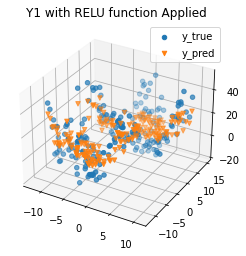

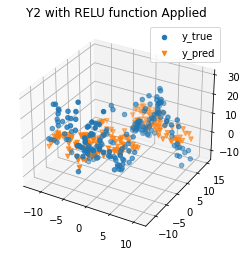

In [43]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU function Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU function Applied', X, y_true[:,1], y_pred[:,1])

# Training with Activation function RELU

In [44]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation='')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE: {}'.format(err))

Layerwise Neural Net Architecture:
=== Layer 0 ===
=== Layer 1 ===
=== Layer 2 ===

Calculated Error in each epoch:  232.9753233538026
Calculated Error in each epoch:  178.62547698647657
Calculated Error in each epoch:  168.64936084782337
Calculated Error in each epoch:  171.72243072260335
Calculated Error in each epoch:  208.77150477070157
Calculated Error in each epoch:  159.6351350863116
Calculated Error in each epoch:  162.46567863255274
Calculated Error in each epoch:  180.1549428788272
Calculated Error in each epoch:  157.61861706949168
Calculated Error in each epoch:  164.548477342183
Calculated Error in each epoch:  162.16960006548464
Calculated Error in each epoch:  177.96093821509422
Calculated Error in each epoch:  155.8080237784438
Calculated Error in each epoch:  159.05420245741223
Calculated Error in each epoch:  158.99130070361866
Calculated Error in each epoch:  167.6964530302941
Calculated Error in each epoch:  157.85070642067902
Calculated Error in each epoch:  164.07

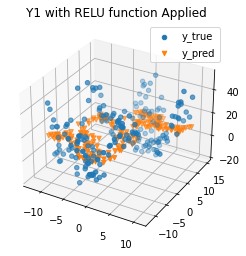

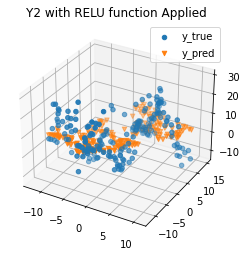

In [45]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU function Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU function Applied', X, y_true[:,1], y_pred[:,1])